In [1]:
## import stuff

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import tensorflow as tf
import random
import matplotlib.pyplot as plt

%matplotlib inline
import os
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import gc 

In [2]:
gc.collect()

132

In [3]:
## import the tablular data info

data_train = pd.read_csv('train.csv')
data_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


## data attributes

In [4]:
data_train.shape

(33126, 8)

In [5]:
data_train.patient_id.nunique()

2056

In [6]:
data_train.target.sum()/data_train.target.count()

0.01762965646320111

In [7]:
(data_train.target.count()-data_train.target.sum())/data_train.target.sum()

55.72260273972603

In [8]:
## max number of pics for an individual patient
# and the total bads for him/her

data_train[['patient_id'
            ,'image_name'
            ,'target']].groupby('patient_id').agg({'image_name':'count'
                                                   ,'target':'sum'}).reset_index().sort_values('image_name'
                                                                                                , ascending=False).head(6)

,patient_id,image_name,target
1453,IP_7279968,115,0
921,IP_4479736,115,0
998,IP_4938382,115,1
900,IP_4382720,115,0
114,IP_0656529,114,0
922,IP_4488328,104,0


In [9]:
## list of the top five patients in terms of image numbers

ls = ['IP_7279968','IP_4479736','IP_4938382','IP_4382720','IP_0656529','IP_4488328']

### Look at patients with 100+ images and their distribution across diagnosis, image region and others

In [10]:
data_train[data_train.patient_id.isin(ls)].groupby(['patient_id'
                                                   ,'diagnosis']).agg({'image_name':'count'
                                                                      })

image_name
patient_id diagnosis            
IP_0656529 unknown           114
IP_4382720 unknown           115
IP_4479736 unknown           115
IP_4488328 unknown           104
IP_4938382 melanoma            1
           nevus              11
           unknown           103
IP_7279968 unknown           115

In [11]:
data_train[data_train.patient_id.isin(ls)].groupby(['patient_id'
                                                   ,'benign_malignant']).agg({'image_name':'count'
                                                                      })

image_name
patient_id benign_malignant            
IP_0656529 benign                   114
IP_4382720 benign                   115
IP_4479736 benign                   115
IP_4488328 benign                   104
IP_4938382 benign                   114
           malignant                  1
IP_7279968 benign                   115

In [12]:
data_train[data_train.patient_id.isin(ls)].groupby(['patient_id'
                                                   ,'anatom_site_general_challenge']).agg({'image_name':'count'
                                                                      }).reset_index().pivot_table(values ='image_name' 
                                                                                                   , index = 'patient_id'
                                                                                                   , columns = 'anatom_site_general_challenge')

anatom_site_general_challenge,head/neck,lower extremity,torso,upper extremity
patient_id,,,,
IP_0656529,16,36,41,21
IP_4382720,1,59,27,28
IP_4479736,4,47,40,24
IP_4488328,8,11,63,22
IP_4938382,1,19,76,18
IP_7279968,16,2,77,20


In [13]:
data_train[data_train.patient_id.isin(ls)].groupby(['patient_id'
                                                   ,'target']).agg({'image_name':'count'
                                                                      }).reset_index().pivot_table(values ='image_name' 
                                                                                                   , index = 'patient_id'
                                                                                                   , columns = 'target')

target,0,1
patient_id,,
IP_0656529,114.0,NaN
IP_4382720,115.0,NaN
IP_4479736,115.0,NaN
IP_4488328,104.0,NaN
IP_4938382,114.0,1.0
IP_7279968,115.0,NaN


In [14]:
data_train.anatom_site_general_challenge.value_counts()

torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64

In [15]:
data_train.benign_malignant.value_counts()

benign       32542
malignant      584
Name: benign_malignant, dtype: int64

In [16]:
data_train.diagnosis.value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64

In [17]:
data_train.sex.value_counts()

male      17080
female    15981
Name: sex, dtype: int64

In [18]:
# age distribution in the data
data_train[['patient_id','sex']].drop_duplicates()['sex'].value_counts()
#data_train[['patient_id','sex']].drop_duplicates().hist()

## some patients have aged

male      1077
female     977
Name: sex, dtype: int64

3497


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14645c5e0>]],
      dtype=object)

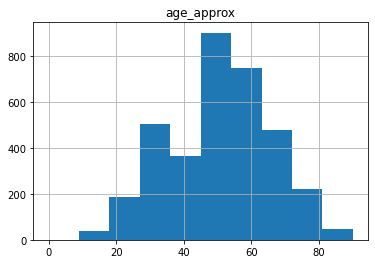

In [19]:
# age distribution in the data
print(data_train[['patient_id','age_approx']].drop_duplicates().shape[0])
data_train[['patient_id','age_approx']].drop_duplicates().hist()

## some patients have aged

## look at image data

In [20]:
data_dir = 'jpeg/train/'
train_files = os.listdir(data_dir)

In [21]:
len(train_files)

33126

In [22]:
## dict of the image and its target
data_train.image_name = data_train.image_name.astype(str) + str('.jpg')
target_dict = pd.Series(data_train.target.values, index = data_train.image_name).to_dict()

In [23]:
## list of melanoma and not melanoma images
ls_melanoma = []
ls_no_melanoma = []
for k,v in target_dict.items():
    if v == 1:
        ls_melanoma.append(k)
    if v == 0:
        ls_no_melanoma.append(k)

In [24]:
random.choice(ls_no_melanoma)

'ISIC_2518443.jpg'

No melanoma images 

(2592, 3888, 3)
ISIC_2119201.jpg


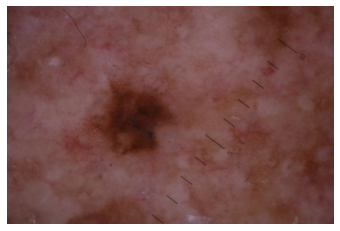

(4000, 6000, 3)
ISIC_5467675.jpg


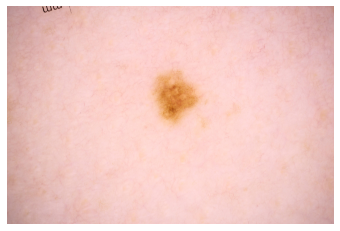

(1053, 1872, 3)
ISIC_0416856.jpg


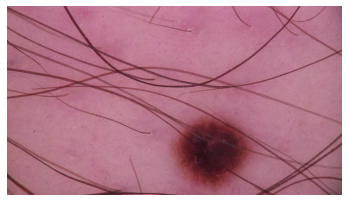

(3456, 5184, 3)
ISIC_7260365.jpg


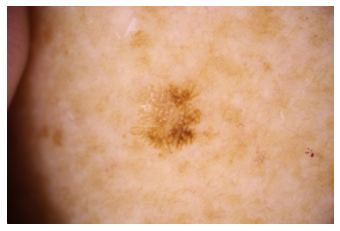

In [25]:
print('No melanoma images \n')
for i in range(1,5):
    pic = random.choice(ls_no_melanoma)
    img = mpimg.imread(os.path.join(data_dir, pic))
    print(img.shape)
    print(pic)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

Melanoma images 

(4000, 6000, 3)
ISIC_7205745.jpg


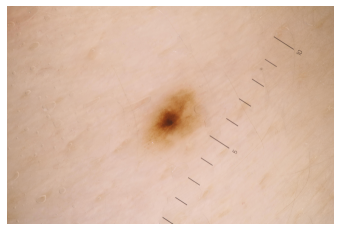

(480, 640, 3)
ISIC_4523382.jpg


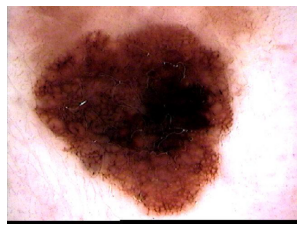

(1053, 1872, 3)
ISIC_5044438.jpg


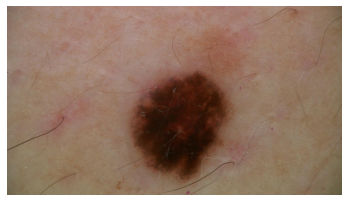

(3456, 5184, 3)
ISIC_2565206.jpg


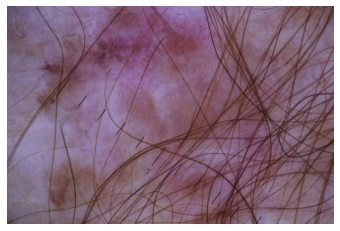

In [26]:
print('Melanoma images \n')
for i in range(1,5):
    pic = random.choice(ls_melanoma)
    img = mpimg.imread(os.path.join(data_dir, pic))
    print(img.shape)
    print(pic)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

In [27]:
gc.collect()

18435

#### general observations of the images 
- the discoloration is fairly centered in each image
- some images are circular or have a black paper in the edge - center crop of some sort necessary 
- some slides have hair - use the hair removal logic from kaggle
- some have an interesting purple color pigmentation 

## Body Hair Analysis - blackhat filter

In [28]:
import cv2

In [69]:
def hair_remove(image):
    kernel = cv2.getStructuringElement(1,(15,15)) 
    # Reading the image named 'input.jpg' 
    input_image = cv2.imread(image) 
    ## resize the image
    image_resize = cv2.resize(input_image,(512,512))
    ## blacknwhite
    input_image_gray = cv2.cvtColor(image_resize, cv2.COLOR_RGB2GRAY)
    # Applying the Black-Hat operation 
    tophat_img = cv2.morphologyEx(input_image_gray
                                  , cv2.MORPH_BLACKHAT
                                  , kernel)
    ## threshold the image to increase the hair intensity
    ret,thresh_img = cv2.threshold(tophat_img,10,255,cv2.THRESH_BINARY)
    ## remove it 
    pre_out = cv2.inpaint(image_resize,thresh_img,1,cv2.INPAINT_TELEA)
    ## convert back to rgb 
    out = cv2.cvtColor(pre_out, cv2.COLOR_BGR2RGB)
    return out

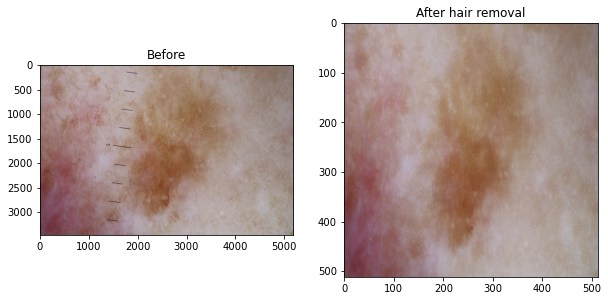

In [30]:
pic = os.path.join(data_dir, random.choice(ls_no_melanoma))
img = mpimg.imread(pic)
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Before')
plt.subplot(1, 2, 2)
plt.imshow(hair_remove(pic))
plt.title('After hair removal')
plt.show()

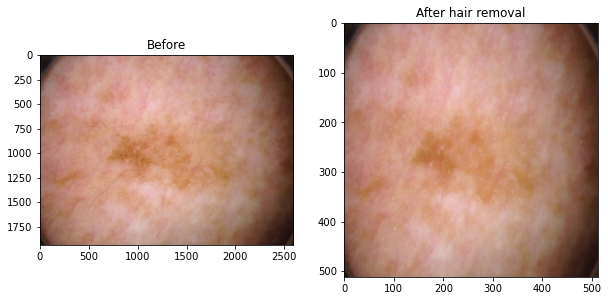

In [31]:
pic = os.path.join(data_dir, random.choice(ls_melanoma))
img = mpimg.imread(pic)
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Before')
plt.subplot(1, 2, 2)
plt.imshow(hair_remove(pic))
plt.title('After hair removal')
plt.show()

## Hair removed training data operation and saving - Parallel

- remove hair on images using the above function 
- create new directory with a folder for no melanoma and melanoma images (will help keras imagegenerator)
- uses multiprocessing package, couldnt get it to run from jupyter notebook
- Also, this is probably **dumb**, pass a custom preprocessing function to keras' imagedatagenerator or use tf.data apis to create a data pipeline

In [32]:
## make new directory
! mkdir 'train_data_with_class'

In [33]:
%%time
## run the hair removing script - this will remove body hair from all images and save in the above directory
! python3 preprocess_hair_remove.py

CPU times: user 32 s, sys: 10.3 s, total: 42.3 s
Wall time: 40min 32s


In [36]:
## create class directories
! mkdir 'train_data_with_class/no_melanoma'
! mkdir 'train_data_with_class/melanoma'
melanoma_dir = 'train_data_with_class/melanoma'
no_melanoma_dir = 'train_data_with_class/no_melanoma'

mkdir: train_data_with_class/no_melanoma: File exists
mkdir: train_data_with_class/melanoma: File exists


In [37]:
## move images to class specific directories

## creating no melanoma dir
for i in ls_no_melanoma:
    shutil.move(os.path.join('train_data_with_class', i), os.path.join(no_melanoma_dir, i))
    

## creating melanoma dir
for i in ls_melanoma:
    shutil.move(os.path.join('train_data_with_class', i), os.path.join(melanoma_dir, i))

## Image loading and Augmentation

In [70]:
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

## some additional data augmentation
training_datagen = ImageDataGenerator(
    rescale = 1./255
    , rotation_range=40
    , width_shift_range=0.2 
    , height_shift_range=0.2 
    , zoom_range=0.2
    , horizontal_flip=True
    , fill_mode='nearest')

## utilize the new directory structure to infer classes
train_generator = training_datagen.flow_from_directory(
    'train_data_with_class'
    , target_size=(512,512)
    , class_mode='binary'
    , batch_size=100
)

Found 33126 images belonging to 2 classes.


## Sample Model build

In [58]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3), activation = 'relu', input_shape = (512,512,3))
    , tf.keras.layers.MaxPooling2D(2,2)
    , tf.keras.layers.Conv2D(32,(3,3), activation = 'relu')
    , tf.keras.layers.MaxPooling2D(2,2)
    , tf.keras.layers.Conv2D(32,(3,3), activation = 'relu')
    , tf.keras.layers.MaxPooling2D(2,2)
    , tf.keras.layers.Flatten()
    , tf.keras.layers.Dense(512, activation = 'relu')
    , tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 510, 510, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 255, 255, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 253, 253, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 123008)           

In [60]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(lr = 0.001)
              , loss = 'binary_crossentropy'
              , metrics = ['accuracy',tf.keras.metrics.AUC()])

In [62]:
history = model.fit(train_generator
                    , steps_per_epoch = 100
                    , epochs = 70
                    , verbose = 1)

Epoch 1/70
100/100 [==============================] - 732s 7s/step - loss: 0.0915 - accuracy: 0.9812 - auc: 0.6631
Epoch 2/70
100/100 [==============================] - 731s 7s/step - loss: 0.0857 - accuracy: 0.9829 - auc: 0.6507
Epoch 3/70
100/100 [==============================] - 728s 7s/step - loss: 0.0858 - accuracy: 0.9828 - auc: 0.6532
Epoch 4/70
100/100 [==============================] - 726s 7s/step - loss: 0.0839 - accuracy: 0.9833 - auc: 0.6565
Epoch 5/70
100/100 [==============================] - 728s 7s/step - loss: 0.0829 - accuracy: 0.9836 - auc: 0.6523
Epoch 6/70
100/100 [==============================] - 725s 7s/step - loss: 0.0929 - accuracy: 0.9814 - auc: 0.6473
Epoch 7/70
100/100 [==============================] - 726s 7s/step - loss: 0.0878 - accuracy: 0.9824 - auc: 0.6441
Epoch 8/70
100/100 [==============================] - 726s 7s/step - loss: 0.1100 - accuracy: 0.9825 - auc: 0.6402
Epoch 9/70
100/100 [==============================] - 729s 7s/step - loss: 0.087

In [63]:
## sample model dint really do much

## Testing - sample model

- preprocess the test images
    - hair removal 
    - resize
- predict and create a submission csv

In [45]:
! mkdir 'test_preprocessed'

In [46]:
%%time
## run the hair removing script - 
## this will remove body hair 
## and resize from all images and save in the above directory
! python3 test_preprocess_hair_remove.py

CPU times: user 12.7 s, sys: 4.11 s, total: 16.8 s
Wall time: 15min 51s


In [49]:
## for some reason image generator only pulls from a subfolder so lets create a new folder and move the processed images into it
test_images = os.listdir('test_preprocessed')
    
! mkdir 'test_preprocessed/test'

for i in test_images:
    shutil.move(os.path.join('test_preprocessed', i), os.path.join('test_preprocessed/test', i))

Found 10982 images belonging to 1 classes.


In [64]:
test_datagen = ImageDataGenerator(
    rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    'test_preprocessed'
    , target_size=(512,512)
    , class_mode=None
    , batch_size=50
    , shuffle = False
)

Found 10982 images belonging to 1 classes.


In [65]:
## alright lets use this to predict probabilities
pred=model.predict_generator(test_generator,verbose=1)

220/220 [==============================] - 146s 663ms/step


In [66]:
submission = pd.DataFrame({'image_name':test_images
                           , 'target':pred.reshape(10982,)})

submission['image_name'] = submission['image_name'].str.replace('.jpg','')
submission.head()

,image_name,target
0,ISIC_6825769,0.994568
1,ISIC_3711637,0.995294
2,ISIC_6290714,0.996668
3,ISIC_8562507,0.996756
4,ISIC_8558857,0.989094


In [68]:
submission.to_csv('submission_sample_model.csv', index = False)